In [1]:
import numpy as np
%matplotlib inline

# NOTE: we are storing y's as 1's or 0's but still doing the mean stuff correctly
def get_sample(n, mean, var):
    x_sample = []
    y_sample = []
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.normal(-mean, var)
        else:
            x = np.random.normal(mean, var)
        x_sample.append(x)
        y_sample.append(y)
    return x_sample, y_sample

import seaborn as sns
import matplotlib.pyplot as plt


def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_sample(5000, 2, 1)
sample = list(zip(X, y))
class_two, class_neg_two = split_by_class(sample)



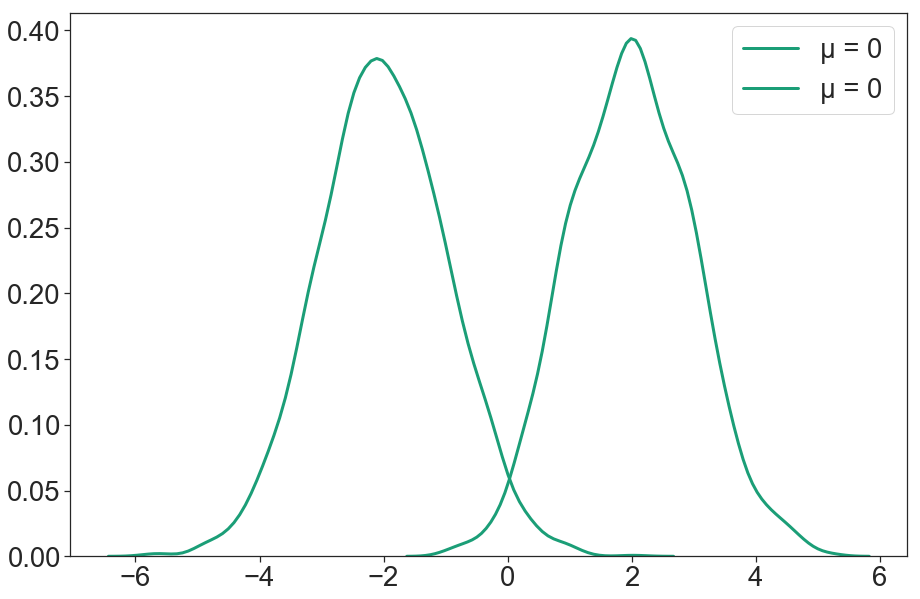

In [2]:
sns.set(font_scale = 2.5)
sns.set_style("ticks")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['lines.linewidth'] = 3
plt.figure()

sns.distplot(list(zip(*class_two))[0], hist=False, color = "#1b9e77", label = u'\u03bc = 0')
sns.distplot(list(zip(*class_neg_two))[0], hist=False, color = "#1b9e77", label = u'\u03bc = 0')

In [72]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import math


def rf_entropy_estimate_bagging_revised(X, y, n_estimators = 300, nu = .33, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=nu, random_state=42)
    
    max_samples = int(X_train.shape[0]*.5)
    split_samples = max_samples // 2
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= split_samples, 
                              bootstrap = bootstrap)
    model.fit(X_train, y_train)
    class_counts = np.zeros((X_test.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices = unsampled_indices[:split_samples]

        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in unsampled_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(model.n_classes_*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - (model.n_classes_ - 1)/(model.n_classes_*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X_test)])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X_test)]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    print(probs)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

from scipy.stats import entropy

def get_entropy(X):
    probs = np.bincount(X)/len(X)
    return entropy(probs)

def get_mutual_information(X, y, n_estimators = 1000, max_samples = .32, depth = 40):
    cond_entropy = rf_entropy_estimate_bagging(X, y, n_estimators = n_estimators, max_samples = max_samples, depth = depth)
    h_y = get_entropy(y)
    return h_y - cond_entropy


np.warnings.filterwarnings('ignore')


In [77]:
X, y = get_sample(10000, 1, 1)


In [76]:
rf_entropy_estimate_bagging_revised(np.array(X).reshape(-1, 1), y)

[[0.39322853 0.60677147]
 [0.01573133 0.98426867]
 [0.44930958 0.55069042]
 ...
 [0.01934091 0.98065909]
 [0.31604062 0.68395938]
 [0.1710981  0.8289019 ]]


0.3486389528698926

In [78]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math


def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 500, .32)


0.37482170662016545

# Hard moon case:

In [84]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

In [87]:
def sample_moons(n_samples):
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
    return noisy_moons

In [93]:
np.random.seed(0)
X, y = sample_moons(5000)

In [94]:
rf_entropy_estimate_bagging(X, y)

0.040597675712092954

In [90]:
rf_entropy_estimate_bagging_revised(X, y)

[[0.99344393 0.00655607]
 [0.99078443 0.00921557]
 [0.99274003 0.00725997]
 ...
 [0.00474596 0.99525404]
 [0.00474596 0.99525404]
 [0.00542391 0.99457609]]


0.05714580736017023

In [96]:
get_entropy(y)

0.6931471805599453

In [95]:
get_mutual_information(X, y)

0.6501380903249481

In [97]:
.6501/.693147

0.9378962903972751